In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression

In [4]:
import random
from matplotlib.colors import ListedColormap

## Исходные функции

In [5]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [6]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [7]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [15]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [18]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    print("Nimber of correct answers is ", correct, "of ", len(actual))
    return correct / float(len(actual)) * 100.0

## Домашнее задание

**1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).**


In [19]:
classification_data, classification_labels = make_classification(n_features=2, 
                                                                 n_informative=2, 
                                                                 n_classes=2, 
                                                                 n_redundant=0,
                                                                 n_clusters_per_class=1, 
                                                                 random_state=250, 
                                                                 n_samples=100)

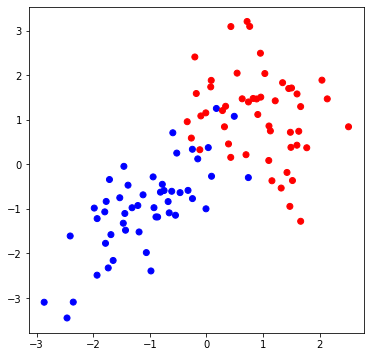

In [20]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,6))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [21]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [22]:
train_data

array([[-0.74840146, -0.58731219],
       [ 1.48300477,  0.72077938],
       [-1.68732763, -1.57771442],
       [-0.59389287,  0.70998809],
       [-1.4416142 , -1.10300421],
       [ 0.63131503,  1.47276735],
       [-0.98015592, -2.39377005],
       [-0.86240844, -1.18172787],
       [-0.8126212 , -0.62397904],
       [-0.94204293, -0.28128702],
       [-2.86659669, -3.09648876],
       [ 1.10452433,  0.86225757],
       [-0.46586078, -0.63427626],
       [-2.46284987, -3.44996638],
       [ 0.07560736,  1.73999696],
       [-1.21203956, -0.92380383],
       [ 0.95961168,  1.51010261],
       [-0.89192741, -1.18056016],
       [ 0.95344964,  2.49659943],
       [-0.26680251,  0.5909157 ],
       [-1.42952336, -1.47872396],
       [ 0.74007773, -0.29682173],
       [-0.20507593,  2.41237003],
       [ 2.5098417 ,  0.84437207],
       [-0.61327594, -0.60434638],
       [ 1.42264114, -0.18118826],
       [-1.93081594, -1.21798822],
       [ 1.6643484 , -1.27788959],
       [ 0.71813602,

In [23]:
test_data

array([[ 1.34497424,  1.83469156],
       [-1.98187659, -0.98173546],
       [ 0.88627303,  1.46893122],
       [ 0.49145238,  1.07957062],
       [ 0.76391488,  3.09892476],
       [-0.77960612, -0.44759042],
       [-1.73497856, -2.32585743],
       [ 2.13410665,  1.47119527],
       [ 1.32004246, -0.53197477],
       [-0.92671127, -0.97267058],
       [ 0.28304314,  1.20860235],
       [ 1.03166169,  2.04036904],
       [ 0.54159004,  2.04909024],
       [-0.32554805, -0.58431051],
       [ 0.82471246,  1.48053952],
       [ 0.08452531,  1.88650568],
       [ 1.1008187 ,  0.08734892],
       [-0.24847596,  0.33926729],
       [ 1.77170522,  0.37342026],
       [-1.77106207, -0.83242045],
       [ 1.47364587, -0.94343852],
       [-0.65778233, -1.08861705],
       [ 1.1294402 ,  0.75151507],
       [-0.33963108,  0.95855915],
       [ 0.33854576,  1.30484759],
       [-0.54685327, -1.14250686],
       [-1.53102686, -0.74940448],
       [ 0.03218158,  0.37690982],
       [ 0.42912697,

In [24]:
train_labels

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0])

In [25]:
test_labels

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1])

### 1 дерево

In [35]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 12 ms


In [36]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [37]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [38]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.5f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.5f}')

Nimber of correct answers is  66 of  70
Точность случайного леса из 1 деревьев на обучающей выборке: 94.28571
Nimber of correct answers is  27 of  30
Точность случайного леса из 1 деревьев на тестовой выборке: 90.00000


Т.к. визуализируем лес, то необходимо поменять название функции возвращающей данные и изменить порядок аргументов относительно функции из урока.  
Также добавлена передача посчитанных метрик параметрами, чтобы подписи к графикам отражали текущую величину метрики

In [41]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_accuracy, test_accuracy, train_data, test_data, model):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.5f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.5f}')

<ipython-input-41-9028dcc99e39>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-41-9028dcc99e39>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


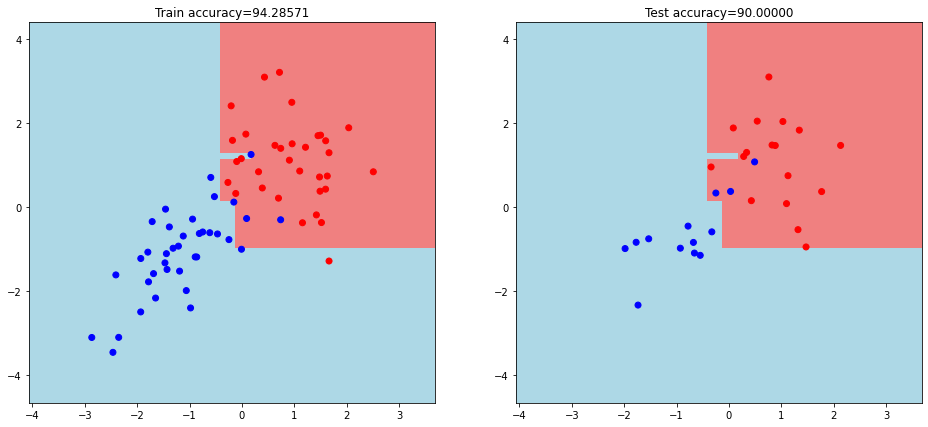

In [42]:
visualize(train_accuracy, test_accuracy, train_data, test_data, my_forest_1)

### 3 дерева

In [32]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 21 ms


In [33]:
# Получим ответы для обучающей выборки 
train_answers_3 = tree_vote(my_forest_3, train_data)

In [34]:
# И получим ответы для тестовой выборки
test_answers_3 = tree_vote(my_forest_3, test_data)

In [35]:
# Точность на обучающей выборке
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_3:.5f}')

# Точность на тестовой выборке
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_3:.5f}')

Nimber of correct answers is  68 of  70
Точность случайного леса из 3 деревьев на обучающей выборке: 97.14286
Nimber of correct answers is  26 of  30
Точность случайного леса из 3 деревьев на тестовой выборке: 86.66667


<ipython-input-30-9028dcc99e39>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-30-9028dcc99e39>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


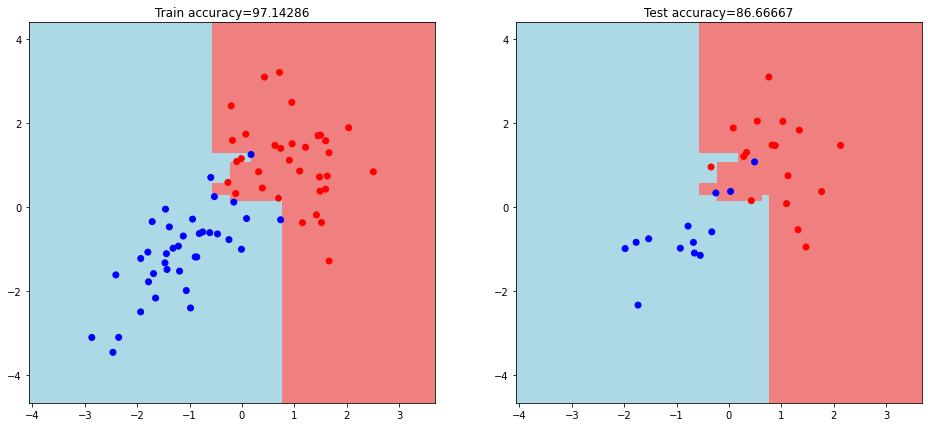

In [36]:
visualize(train_accuracy_3, test_accuracy_3, train_data, test_data, my_forest_3)

### 10 деревьев

In [37]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 60 ms


In [38]:
# Получим ответы для обучающей выборки 
train_answers_10 = tree_vote(my_forest_10, train_data)

In [39]:
# И получим ответы для тестовой выборки
test_answers_10 = tree_vote(my_forest_10, test_data)

In [40]:
# Точность на обучающей выборке
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10:.3f}')

# Точность на тестовой выборке
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_10:.3f}')

Nimber of correct answers is  69 of  70
Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Nimber of correct answers is  26 of  30
Точность случайного леса из 10 деревьев на тестовой выборке: 86.667


<ipython-input-30-9028dcc99e39>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-30-9028dcc99e39>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


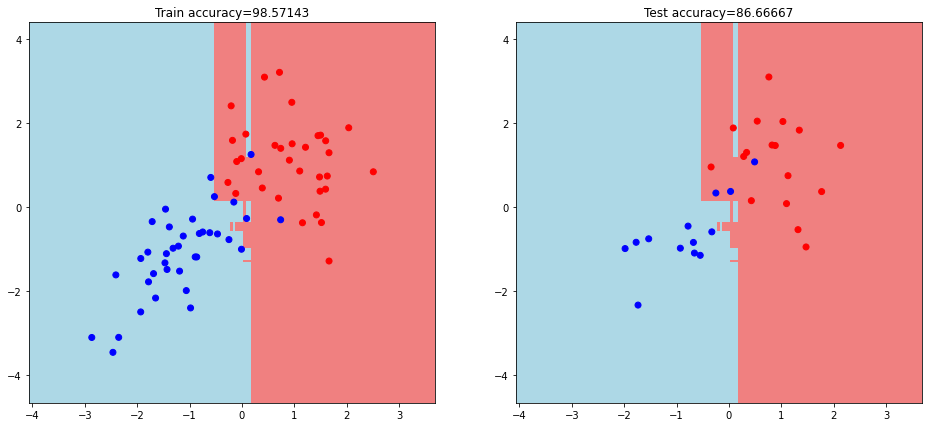

In [41]:
visualize(train_accuracy_10, test_accuracy_10, train_data, test_data, my_forest_10)

### 50 деревьев

In [42]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 250 ms


In [43]:
# Получим ответы для обучающей выборки 
train_answers_50 = tree_vote(my_forest_50, train_data)

In [44]:
# И получим ответы для тестовой выборки
test_answers_50 = tree_vote(my_forest_50, test_data)

In [45]:
# Точность на обучающей выборке
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_50:.3f}')

# Точность на тестовой выборке
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_50:.3f}')

Nimber of correct answers is  70 of  70
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Nimber of correct answers is  27 of  30
Точность случайного леса из 50 деревьев на тестовой выборке: 90.000


<ipython-input-30-9028dcc99e39>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-30-9028dcc99e39>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


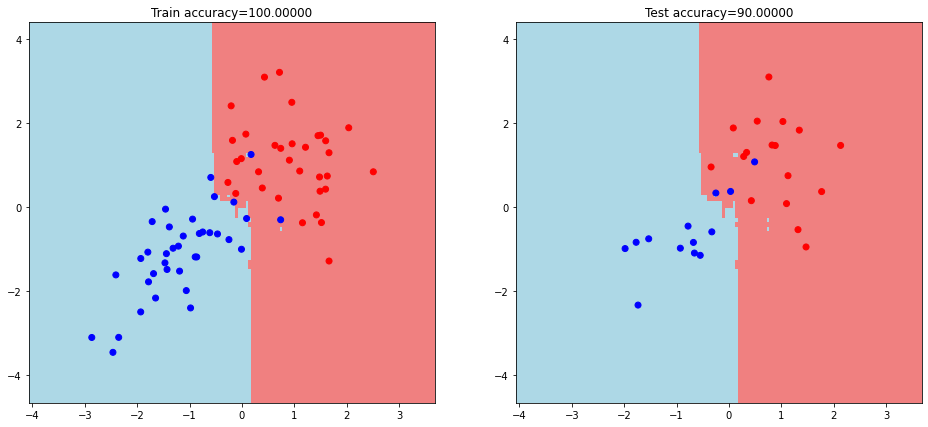

In [46]:
visualize(train_accuracy_50, test_accuracy_50, train_data, test_data, my_forest_50)

**2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**



Выводы:
- Увеличение количества деревьев всегда приводит к увеличению точности на тренировочной выборке. Но, похоже, количество деревьев большее, чем количество наблюдений не приведет к какому-либо эффекту.
- Но увеличение количества деревьев далеко не всегда приводит к увеличению точности предсказаний на тествовй выборке.
- На графиках можно увидеть, что с увеличением количества деревььев гиперплоскость усложняется и более полно охватывает все объекты на тренировочной выборке. При этом далеко не всегда оптимизированная для тренировки гиперплоскость соответсвует по форме оптимальной гиперплоскости для теста
- Можно предположить, что этотт эффект нивелируется с увеличением количества объектов, но базовые положения останутся актуальными.  

Т.е. лес с количеством деревьев выше определенного оптимального порога склонен к переобучению.  
Все вышеуказанное справедливо для Random Forest без ограничения глубины деревьев. 

**3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**



Переменные

In [88]:
tree_max_depth = 3
min_samples_split_gl = 2
min_samples_leaf_gl = 1

Для функции нахождения наилучшего разбиения особенных изменений нет за исключением добавленных условий.

In [80]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf_samples=5):
    
    #  обозначим минимальное количество объектов в узле
    #min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

Просто изменено название класса или функции.

In [150]:
class Leaf_oob:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [ ]:
# Функция классификации отдельного объекта

def classify_object_oob(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf_oob):
        answer = node.prediction
        return answer
    
    #print(node.t)
    #print(obj)
    
    
    if obj[node.index] <= node.t:
        return classify_object_oob(obj, node.true_branch)
    else:
        return classify_object_oob(obj, node.false_branch)

Функция, предназначенная для подсчета OOB

Подсчет величины OOB 
В отличии от исходной функции, возвращается отношение.

In [111]:
def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_oob(X_test[i], tree)
        #print("pred=", pred)
        if pred != y_test[i]:
            mis_label += 1
    #print(mis_label / len(X_test))
    return mis_label / len(X_test)       

In [143]:
def predict_oob(data, tree):    
    classes = []
    #print(data)
    for obj in data:
        prediction = classify_object_oob(obj, tree)
        print(prediction)
    return classes

Доработка исходной функции для возврата массива с неиспользованными объектами

In [54]:
def get_bootstrap_oob(data, labels):#, n_trees):
    bootstrap = [] #list with data which shoul be returned
    oob_list = [] # list with data which are not in samples
    
    
    # Выбор индексов для бутстрапа и остаток выбирается как индексы для OOB    
    n_samples = int(data.shape[0]) # размер совпадает с исходной выборкой    
    
    #for i in range(n_trees):    
    sample_index = np.random.randint(0, n_samples, size=n_samples)
    oob_indices = [i for i in range(len(data)) if i not in sample_index]
    #sample_index = np.random.randint(0, n_samples, size=n_samples)
    
    #indices with data
    b_x = data[sample_index]
    b_y = labels[sample_index]
    # indices for OOB
    X_oob = data[oob_indices]
    y_oob = labels[oob_indices]
    #bootstrap.append((b_x, b_y, X_oob, y_oob))
        
    return b_x, b_y, X_oob, y_oob #bootstrap 

Измененная функция по нахождению наилучшего разбиения

In [81]:
def build_tree(data, labels, depth = 0 , min_samples_leaf=1, min_samples_split=2):
    
    global tree_max_depth , min_samples_leaf_gl, min_samples_split_gl
    
    if (depth < tree_max_depth) and (data.shape[0] > min_samples_split):
        #print(depth, tree_max_depth)
        gain, t, index = find_best_split(data, labels, min_samples_leaf_gl)
        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree(true_data, true_labels, depth + 1, min_samples_leaf_gl)
        false_branch = build_tree(false_data, false_labels, depth + 1, min_samples_leaf_gl)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    # returning leaf when reaches max depth
    #print("Leaf")
    return Leaf(data, labels)

После изменений bootsrap создается для каждого из деревьев отдельно.  
Из него извлекаются параметры, которые затем обрабатывются

In [113]:
def random_forest_oob(X, y, n_trees):
    forest = [] #main data 
    oob_list = [] # bootstrap data
    
    for j in range(n_trees):
        b_data,  b_labels, test_data, test_labesl = get_bootstrap_oob(X, y)        
        
        #print(b_data.shape[0],  b_labels.shape[0], test_data.shape[0], test_labesl.shape[0])        
        
        tree = (build_tree(b_data, b_labels))
        #print(tree)
        forest.append(tree)
        oob_error = 1 - oob_score(tree, test_data, test_labesl)
        oob_list.append([j, oob_error])
    return forest, oob_list

In [132]:
# предсказание голосованием деревьев

def tree_vote_oob(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        print(predict_oob(data, tree))
        predictions.append(predict_oob(data, tree))
        
    #print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    print(voted_predictions)    
    return voted_predictions

Создание датасета

In [118]:
X, y = make_classification(n_features=2, 
                           n_informative=2, 
                           n_classes=2, 
                           n_redundant=0,
                           n_clusters_per_class=1, 
                           random_state=250, 
                           n_samples=100)

Получение случайного леса

In [100]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize_oob(train_accuracy, train_data, model):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(model, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.5f}')

#     # график тестовой выборки
#     plt.subplot(1,2,2)
#     plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
#     plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
#     plt.title(f'Test accuracy={test_accuracy:.5f}')

**4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.**

Исходная функция:

In [47]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

Формула энтропии с математической точки зрения:
$$E(S) = \sum^{c}_{i=1} -p_{i}log_{2}p_{i}$$  
где p - это частотная вероятность класса 1 в выборке для оценки.

Вне зависимости от класса, по которому ведется вычисление в данном случае, величина энтропии будет одинаковой, поэтому в теле функции жестко прописываем интересующий нас класс 1.  
В случае необходимоти более сложных преобразований, интересующий нас класс можно переавать параметром, но, судя по всему, это не окажет влияния на результат вычислений.

In [48]:
def entropy_2(labels):
        #  подсчет количества объектов разных классов
    classes = {}
    total = 0
    
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
        total +=1
    #  расчет критерия
    print(classes)  
    
    #for labels in classes:
    p = classes[1]/total
    entropy_val =  - p * np.log(p)/np.log(2) - (1-p) * np.log(1-p)/np.log(2)     
    #print(entropy_val)
        
    return entropy_val

Проверка работы функции на небольшом тестовом датасете.

In [49]:
labels = np.array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0])

In [50]:
entropy_2(labels)

{0: 7, 1: 3}


0.8812908992306927

Дальнейшая обработка результатов в целом такая же, как и для критерия Джини.

$$ E(childs) = \sum^{c}_{i=0} p_{i} * E_{i}$$  

где с количество дочерних узлов, а p частотная вероятной наблюдений для этих узлов.  

$$IG = E(parent) - E(childs)$$  